In [1]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import itertools

# Get Data 
---

In [30]:
prices = pd.read_csv("binance_data/From_Paper/2023/1m/merged_From_Paper_closing_prices_OCT_NOV.csv", index_col=0, parse_dates=True)

,BTCEUR_2023_1m,BTCGBP_2023_1m
timestamp,,
2023-10-01 00:00:00,25534.42,22268.92
2023-10-01 00:01:00,25529.86,22268.92
2023-10-01 00:02:00,25528.72,22268.92
2023-10-01 00:03:00,25528.31,22268.92
2023-10-01 00:04:00,25535.11,22268.92
...,...,...
2023-11-30 23:55:00,34647.48,29987.54
2023-11-30 23:56:00,34649.59,29987.54
2023-11-30 23:57:00,34646.25,29987.54


# Trading simulation
---

* ## In-Sample Testing

In [21]:
# cointegrated_pairs = [('BTCEUR_2023_1m',
#   'BTCGBP_2023_1m',
#   0.731393,
#   0.8501886494196308,
#   0.22)]

In [26]:
if cointegrated_pairs:
        sym1, sym2, pass_fraction, avg_p_value,correlation = cointegrated_pairs[0]
        print(f"\nTesting strategy on pair: {sym1} and {sym2} (pass_fractioon: {pass_fraction:.4f},average_p_value: {avg_p_value:.4f} correlation: {correlation:.4f})")
        S1 = prices[sym1]
        S2 = prices[sym2]
        
        # Compute the spread series and beta_series 
        spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size=1440)
        #print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")
        
        # Compute rolling z-score using the provided helper function.
        zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size = 1440)
        
        # Generate trading signals (positions) based on the spread's z-score
        positions_series, win_indexs, loss_indexs = backtest_pair_rolling(spread_series,zscore_series, entry_threshold=1.0, exit_threshold=0.1, stop_loss_threshold=2.0)

        #Simulate strategy performance
        #pnl, cum_pnl = simulate_strategy(S1, S2, positions, beta)

        #pnl, cum_pnl = simulate_true_strategy_rolling(S1, S2, positions_series, beta_series)
        


Testing strategy on pair: BTCEUR_2023_1m and BTCGBP_2023_1m (pass_fractioon: 0.7314,average_p_value: 0.8502 correlation: 0.2200)
Total trades closed: 626 (Wins=447, Losses=179)
Win rate: 0.71


In [27]:
daily_pnl_series, cum_pnl_series, cum_pnl_pct_series, shares_S1_list, shares_S2_list = simulate_strategy_pnl(S1, S2, positions_series, beta_series=beta_series, initial_capital=1000)

print(f"Total PnL: {cum_pnl_series[-1]:.2f} EUR")
print(f"Total PnL (%): {cum_pnl_pct_series[-1]:.2f}%")

Total PnL: 677.98 EUR
Total PnL (%): 67.80%


/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_6746/1018564186.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Total PnL: {cum_pnl_series[-1]:.2f} EUR")
/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_6746/1018564186.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Total PnL (%): {cum_pnl_pct_series[-1]:.2f}%")


Average daily PnL: 0.02 EUR
Average daily PnL (%): 0.00%


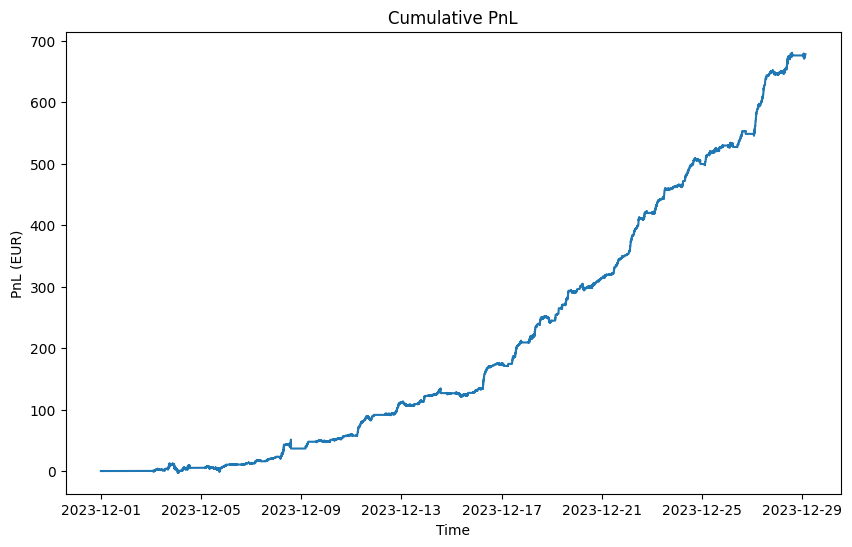

In [28]:
#Plot the cumulative PnL

print(f"Average daily PnL: {daily_pnl_series.mean():.2f} EUR")
print(f"Average daily PnL (%): {daily_pnl_series.mean() / 1000:.2f}%")

plt.figure(figsize=(10,6))
plt.plot(cum_pnl_series)
plt.title('Cumulative PnL')
plt.xlabel('Time')
plt.ylabel('PnL (EUR)')
plt.show()

Long Entries In Window: 237, Short Entries In Window: 952
Wins In Window: 399, Losses In Window: 790


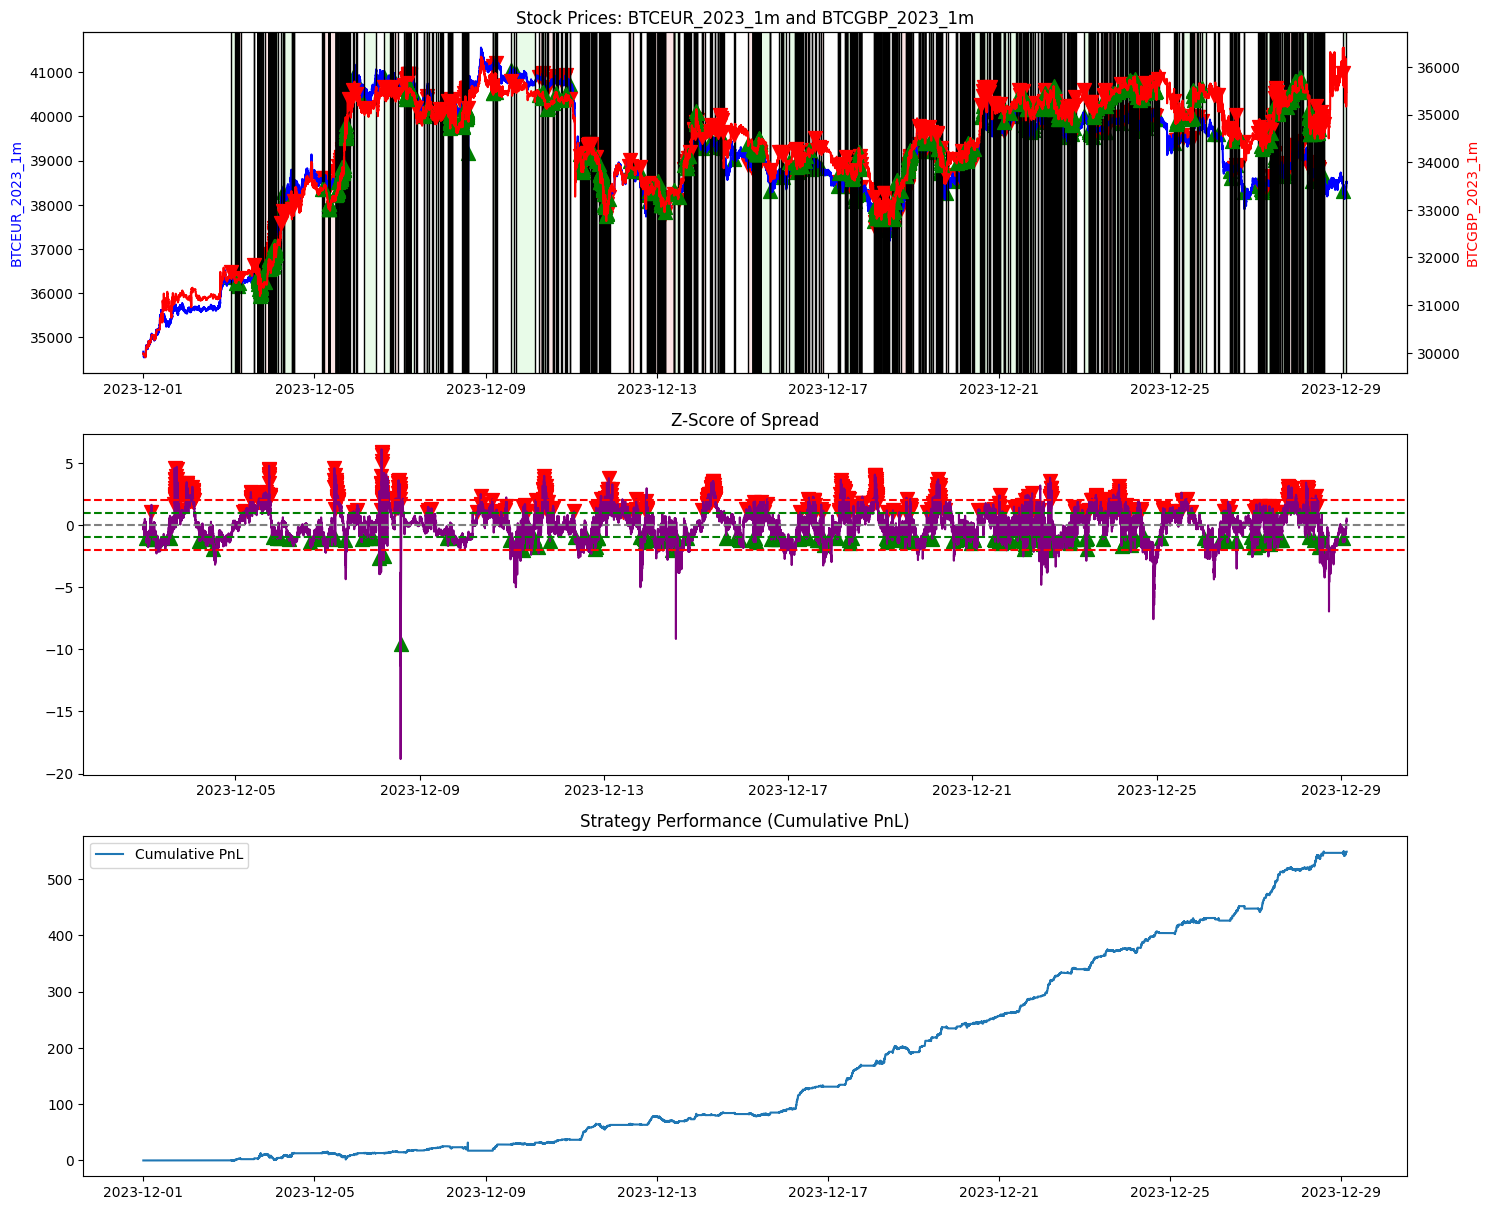

In [25]:
#Plot trading simulation
# window_start = '2023-10-03 00:00:00'
# window_end = '2023-10-03 10:00:00'


# window_start = '2023-10-22 22:43:00'
# window_end = '2023-10-23 22:43:00'

window_start = None
window_end = None

#NOTE THAT THE TIMES ON THE X AXIS SHOW THE HOURS AND MINUTES


plot_trading_simulation(S1, S2, sym1,sym2,zscore_series, positions_series, 
                        cum_pnl_series,win_indexs=win_indexs,loss_indexs=loss_indexs,
                        window_start=window_start, window_end=window_end)



In [50]:
print(cum_pnl_series.loc[window_start:window_end])

timestamp
2023-10-03 00:00:00    0.000000
2023-10-03 00:01:00    0.000000
2023-10-03 00:02:00    0.000000
2023-10-03 00:03:00    0.000000
2023-10-03 00:04:00    0.000000
                         ...   
2023-10-03 09:56:00    3.543622
2023-10-03 09:57:00    3.543622
2023-10-03 09:58:00    3.543622
2023-10-03 09:59:00    3.543622
2023-10-03 10:00:00    3.543622
Length: 601, dtype: float64


In [51]:
# plt.plot(spread_series.loc[window_start:window_end])
# plt.title('Spread Over Time')
# plt.legend()

In [52]:
#zip S1 and S2 together
S1_window = S1.loc[window_start:window_end]
S2_window = S2.loc[window_start:window_end]

#2023-10-23 22:43:00   -20.599535
#compute spread

rolling_mean_window = rolling_mean.loc[window_start:window_end]

rolling_std_window = rolling_std.loc[window_start:window_end]

spread_series_window = spread_series.loc[window_start:window_end]

alpha_series_window = alpha_series.loc[window_start:window_end]

z_score_window = zscore_series.loc[window_start:window_end]

beta_series_window = beta_series.loc[window_start:window_end]

#Merge dataframes together

merged_df = pd.concat([S1_window,S2_window,spread_series_window,rolling_mean_window,rolling_std_window,alpha_series_window,z_score_window,beta_series_window],axis=1)

merged_df.columns = ['S1','S2','Spread','Rolling Mean','Rolling Std','Alpha','Z Score','Beta']

merged_df

,S1,S2,Spread,Rolling Mean,Rolling Std,Alpha,Z Score,Beta
timestamp,,,,,,,,
2023-10-03 00:00:00,26258.63,22828.94,-1.072556,3.685660,37.172008,430.653461,-0.128005,1.131417
2023-10-03 00:01:00,26265.16,22828.94,5.538873,3.676665,37.171591,427.345859,0.050098,1.131558
2023-10-03 00:02:00,26267.97,22846.07,-10.948405,3.661109,37.166117,423.984218,-0.393087,1.131702
2023-10-03 00:03:00,26294.61,22846.07,15.853608,3.622025,37.151855,416.924707,0.329232,1.132004
2023-10-03 00:04:00,26263.55,22857.99,-28.734456,3.655434,37.141199,418.956579,-0.872074,1.131916
...,...,...,...,...,...,...,...,...
2023-10-03 09:56:00,26294.71,22916.53,-62.221950,3.442066,37.241602,-243.519294,-1.763190,1.160754
2023-10-03 09:57:00,26281.84,22916.53,-75.026074,3.387991,37.280382,-247.422657,-2.103360,1.160921
2023-10-03 09:58:00,26285.67,22916.53,-71.116711,3.321861,37.334957,-251.549294,-1.993804,1.161098


Text(0.5, 1.0, 'Time series of S1 and S2 from window start to window end')

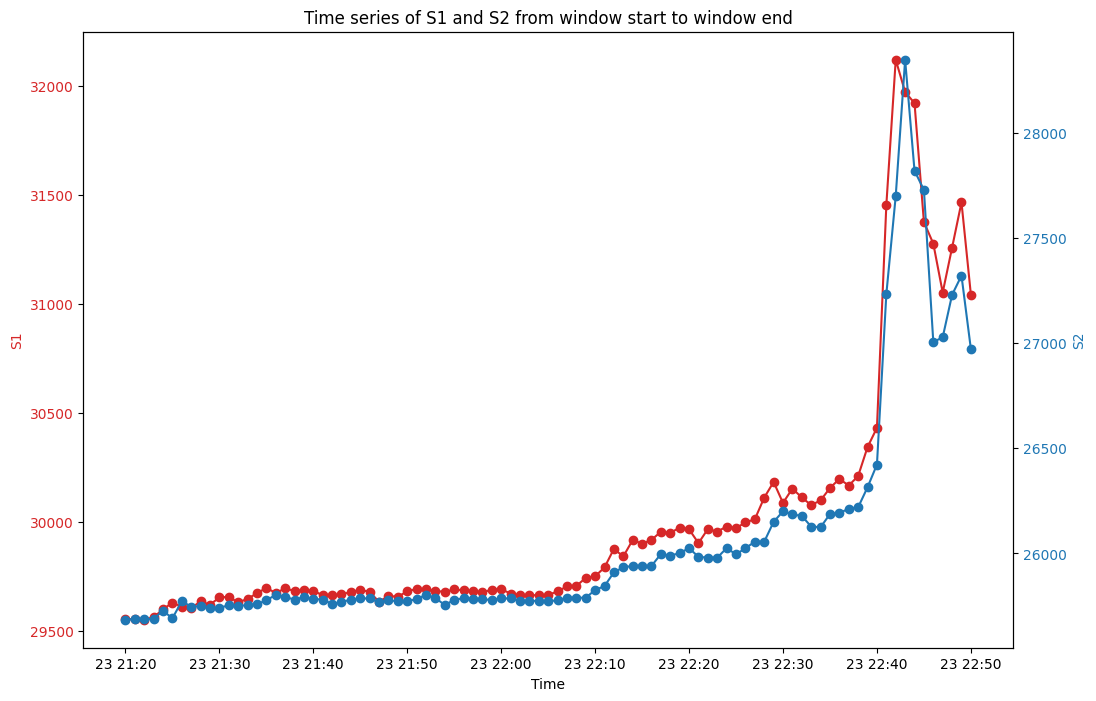

In [53]:
# window_start = '2023-10-23 21:20:00'
# window_end = '2023-10-23 22:50:00'

# #Time of event: 2023-10-23 22:43:00	

# S1_window = S1[window_start:window_end]
# S2_window = S2[window_start:window_end]

# #Plot time series from window start to window end on different y axis and show data points



# fig, ax1 = plt.subplots()

# #Set size of the plot
# fig.set_size_inches(12, 8)

# color = 'tab:red'
# ax1.set_xlabel('Time')
# ax1.set_ylabel('S1', color=color)
# ax1.plot(S1_window, color=color, marker='o')
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()
# color = 'tab:blue'  
# ax2.set_ylabel('S2', color=color)
# ax2.plot(S2_window, color=color, marker='o')
# ax2.tick_params(axis='y', labelcolor=color)

# plt.title('Time series of S1 and S2 from window start to window end')






# # plt.plot(S1_window)
# # plt.plot(S2_window)
# # plt.title('Time series of S1 and S2 from window start to window end')
# # plt.show()

In [54]:
# spre = 31971.76 - (-2.096653) - 1.151277 * 28349.60
# spre